In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy import cos
from math import log
from scipy.interpolate import interp1d
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize

In [2]:
def model(t, z, T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (max(10^-5,R_L - Rain))

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (max(10^-5,Temp - Tmin))
    
    tau_M_curr = tau_M(T_curr)

    # Taxa de infecção de expostos (1/Duração do ciclo esporogônico)
    def b3(tau_M, Temp):
        return 1/tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de picada e probabilidade de transmissão
    def a(Temp):
        return (max(10^-5, Temp - T_linha)) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(Rain) * p_LRT(Rain,Temp) * p_PR(Rain) / (tau_E + tau_L(Temp) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = -a_curr * b2 * (I_M / N) * S_H
    dIhdt = a_curr * b2 * (I_M / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H / N) * S_M - mu_curr * E_M - b3_curr * E_M - l_curr * E_M
    dImdt = b3_curr * E_M - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

Com $\mathcal{R}_0 > 1$ (R0_sir = 0.7915786450042152 , R0_sei = 1.0732299265703247, R0_acoplado = 0.9217081376729355): 

In [3]:
T_linha = 25.6
T1= 26.4 
T2= 0.025
omega1= 0.017
phi1= -1.45

R1= 250.083 
R2= 0.565
omega2= 0.02
phi2=1.6

B_E=200
p_ME=0.9
p_ML=0.75
p_MP=0.85
tau_E=1
tau_P=1
c1=0.019
c2=-0.021

D1=36.5
b1=0.1

A=15
B=15
C=-48.78

b2=0.2
tau_H=10
DD=105
Tmin=14.5
gamma= 1/365 
R_L = 312
N = 8558
M = 300000 
E_M0 = 50000
I_H0 = 1000 
I_M0 = 2500
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0 - I_M0

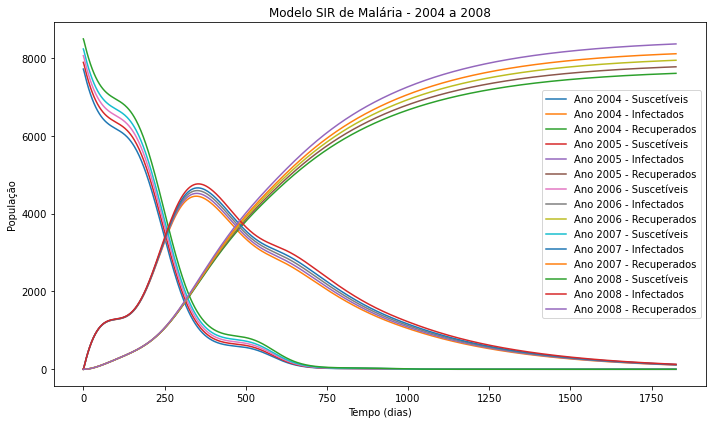

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, year in enumerate(range(2004, 2009)):
    
    pop_rural = [7717, 7889, 8061, 8233, 8492]
    N = pop_rural[i]  
    
    E_M0 = 50000
    I_H0 = 1000 
    I_M0 = 2500
    if E_M0 is None:
        E_M0 = M / 100

    S_H0 = N - I_H0
    S_M0 = M - E_M0 - I_M0
        
    args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)
    
    t_eval = np.linspace(0, 1825, 1000)
    sol = solve_ivp(model, [0, 1825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
    times = sol.t
    S_H, I_H, R_H, S_M, E_M, I_M = sol.y
    
    ax.plot(times, S_H, label=f'Ano {year} - Suscetíveis')
    ax.plot(times, I_H, label=f'Ano {year} - Infectados')
    ax.plot(times, R_H, label=f'Ano {year} - Recuperados')

ax.set_xlabel('Tempo (dias)')
ax.set_ylabel('População')
ax.set_title('Modelo SIR de Malária - 2004 a 2008')
ax.legend()

plt.tight_layout()  
plt.show()

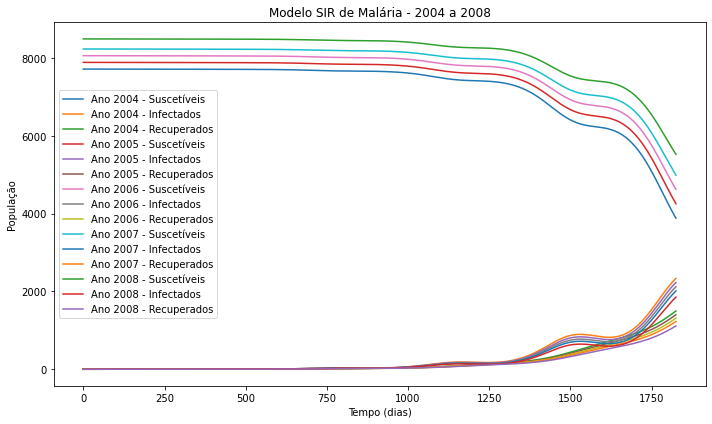

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, year in enumerate(range(2004, 2009)):
    
    pop_rural = [7717, 7889, 8061, 8233, 8492]
    N = pop_rural[i]  
    
    E_M0 = 50000
    I_H0 = 1000 
    I_M0 = 2500
    if E_M0 is None:
        E_M0 = M / 100

    S_H0 = N - I_H0
    S_M0 = M - E_M0 - I_M0
        
    args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)
    
    t_eval = np.linspace(0, 1825, 1000)
    sol = solve_ivp(model, [0, 1825], [N-1, 1, 0, M-2, 1, 1], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
    times = sol.t
    S_H, I_H, R_H, S_M, E_M, I_M = sol.y
    
    ax.plot(times, S_H, label=f'Ano {year} - Suscetíveis')
    ax.plot(times, I_H, label=f'Ano {year} - Infectados')
    ax.plot(times, R_H, label=f'Ano {year} - Recuperados')

ax.set_xlabel('Tempo (dias)')
ax.set_ylabel('População')
ax.set_title('Modelo SIR de Malária - 2004 a 2008')
ax.legend()

plt.tight_layout()  
plt.show()

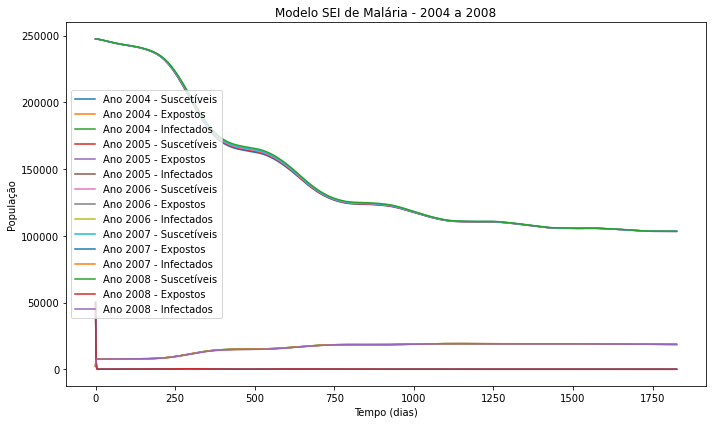

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, year in enumerate(range(2004, 2009)):
    
    pop_rural = [7717, 7889, 8061, 8233, 8492]
    N = pop_rural[i]  
    
    E_M0 = 50000
    I_H0 = 1000 
    I_M0 = 2500
    if E_M0 is None:
        E_M0 = M / 100

    S_H0 = N - I_H0
    S_M0 = M - E_M0 - I_M0
        
    args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)
    
    t_eval = np.linspace(0, 1825, 1000)
    sol = solve_ivp(model, [0, 1825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
    times = sol.t
    S_H, I_H, R_H, S_M, E_M, I_M = sol.y
    
    ax.plot(times, S_M, label=f'Ano {year} - Suscetíveis')
    ax.plot(times, E_M, label=f'Ano {year} - Expostos')
    ax.plot(times, I_M, label=f'Ano {year} - Infectados')

ax.set_xlabel('Tempo (dias)')
ax.set_ylabel('População')
ax.set_title('Modelo SEI de Malária - 2004 a 2008')
ax.legend()

plt.tight_layout()  
plt.show()

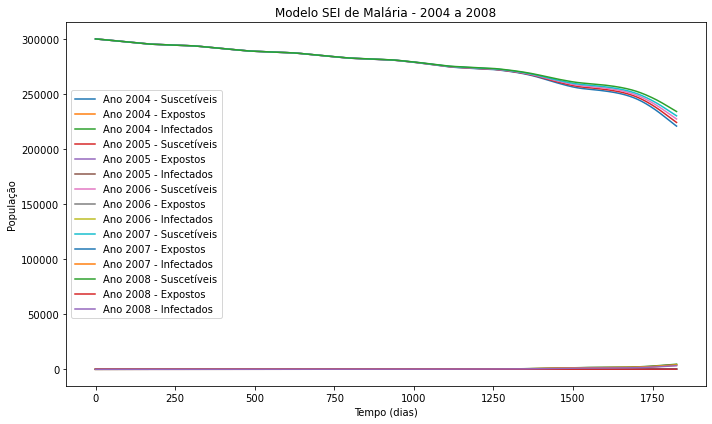

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, year in enumerate(range(2004, 2009)):
    
    pop_rural = [7717, 7889, 8061, 8233, 8492]
    N = pop_rural[i]  
    
    E_M0 = 50000
    I_H0 = 1000 
    I_M0 = 2500
    if E_M0 is None:
        E_M0 = M / 100

    S_H0 = N - I_H0
    S_M0 = M - E_M0 - I_M0
        
    args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)
    
    t_eval = np.linspace(0, 1825, 1000)
    sol = solve_ivp(model, [0, 1825], [N-1, 1, 0, M-2, 1, 1], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
    times = sol.t
    S_H, I_H, R_H, S_M, E_M, I_M = sol.y
    
    ax.plot(times, S_M, label=f'Ano {year} - Suscetíveis')
    ax.plot(times, E_M, label=f'Ano {year} - Expostos')
    ax.plot(times, I_M, label=f'Ano {year} - Infectados')

ax.set_xlabel('Tempo (dias)')
ax.set_ylabel('População')
ax.set_title('Modelo SEI de Malária - 2004 a 2008')
ax.legend()

plt.tight_layout()  
plt.show()

In [8]:
# Cria uma lista com as variações anuais da população
pop_rural = [7717, 7889, 8061, 8233, 8492]
pop_var = [j-i for i, j in zip(pop_rural[:-1], pop_rural[1:])]
pop_var = [i/365 for i in pop_var]  # Divida pela quantidade de dias no ano

# Cria uma função que retorna a variação da população para cada dia do ano
from scipy.interpolate import interp1d
pop_var_fn = interp1d(np.arange(0, 365*len(pop_var), 365), pop_var, fill_value="extrapolate")

def model(t, z, T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (max(10^-5,R_L - Rain))

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (max(10^-5,Temp - Tmin))
    
    tau_M_curr = tau_M(T_curr)

    # Taxa de infecção de expostos (1/Duração do ciclo esporogônico)
    def b3(tau_M, Temp):
        return 1/tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de picada e probabilidade de transmissão
    def a(Temp):
        return (max(10^-5, Temp - T_linha)) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(Rain) * p_LRT(Rain,Temp) * p_PR(Rain) / (tau_E + tau_L(Temp) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    #dShdt = -a_curr * b2 * (I_M / N) * S_H + pop_var_fn(t)
    dShdt = -a_curr * b2 * (I_M / N) * S_H + pop_var_fn(np.mod(t, 365))
    dIhdt = a_curr * b2 * (I_M / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H / N) * S_M - mu_curr * E_M - b3_curr * E_M - l_curr * E_M
    dImdt = b3_curr * E_M - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [9]:
T_linha = 25.6
T1= 26.4 
T2= 0.025
omega1= 0.017
phi1= -1.45

R1= 250.083 
R2= 0.565
omega2= 0.02
phi2=1.6

B_E=200
p_ME=0.9
p_ML=0.75
p_MP=0.85
tau_E=1
tau_P=1
c1=0.019
c2=-0.021

D1=36.5
b1=0.1

A=15
B=15
C=-48.78

b2=0.2
tau_H=10
DD=105
Tmin=14.5
gamma= 1/365 
R_L = 312
N = 8558
M = 300000 
E_M0 = 50000
I_H0 = 1000 
I_M0 = 2500
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0 - I_M0

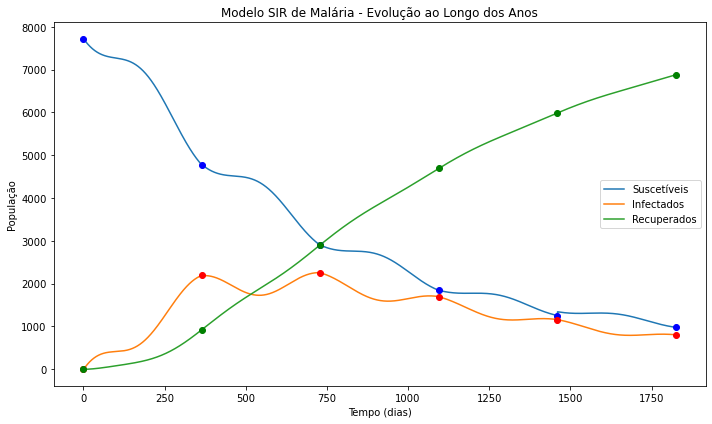

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

all_years_S_H = []
all_years_I_H = []
all_years_R_H = []

all_years_S_M = []
all_years_E_M = []
all_years_I_M = []

for year in range(2004, 2009):
    pop_rural = [7717, 7889, 8061, 8233, 8492]
    N = pop_rural[year - 2004]
    
    if year == 2004:
#         I_H0 = 1000
#         R_H0 = 0
        
#         E_M0 = 50000
#         I_M0 = 2500

        I_H0 = 1
        R_H0 = 0
        
        # Com um único mosquito exposto, a doença não se estabelece
        #E_M0 = 1, 10, 100
        # Começa a se estabelecer com 1000, mas ainda muito pouco
        E_M0 = 50000
        I_M0 = 0
        
    else:
        I_H0 = all_years_I_H[-1][-1]
        R_H0 = all_years_R_H[-1][-1]
        
        #E_M0 = all_years_E_M[-1][-1]
        #I_M0 = all_years_I_M[-1][-1]
        
    if E_M0 is None:
        E_M0 = M / 100
        
        
    S_H0 = N - I_H0 - R_H0
    S_M0 = M - E_M0 - I_M0
    
    args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   36.5, 0.04, A, B, C, 0.09, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)
    
    t_eval = np.linspace(0, 365, 1000)
    sol = solve_ivp(model, [0, 365], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
    times = sol.t
    S_H, I_H, R_H, S_M, E_M, I_M = sol.y
    
    all_years_S_H.append(S_H)
    all_years_I_H.append(I_H)
    all_years_R_H.append(R_H)
    #print(S_H)
    
all_years_S_H = np.concatenate(all_years_S_H, axis=0)    
all_years_I_H = np.concatenate(all_years_I_H, axis=0)
all_years_R_H = np.concatenate(all_years_R_H, axis=0)

time_total = np.linspace(0, 1825, 1000 * 5)  # Tempo total de 5 anos

ax.plot(time_total, all_years_S_H, label='Suscetíveis')
ax.plot(time_total, all_years_I_H, label='Infectados')
ax.plot(time_total, all_years_R_H, label='Recuperados')

time_points = [0, 365, 730, 1095, 1460, 1825]  # Tempos específicos

# Calcula os índices correspondentes nos arrays de tempo total
indices = [np.argmin(np.abs(time_total - t)) for t in time_points]

for index in indices:
    ax.plot(time_total[index], all_years_S_H[index], 'bo')  # Ponto azul para o valor no tempo específico
    ax.plot(time_total[index], all_years_I_H[index], 'ro')  # Ponto vermelho para o valor no tempo específico
    ax.plot(time_total[index], all_years_R_H[index], 'go')  # Ponto verde para o valor no tempo específico

ax.set_xlabel('Tempo (dias)')
ax.set_ylabel('População')
ax.set_title('Modelo SIR de Malária - Evolução ao Longo dos Anos')
ax.legend()

plt.tight_layout()
plt.show()

População em 2004:

In [11]:
all_years_S_H[0]+all_years_I_H[0]+all_years_R_H[0]

7717.0

População em 2005:

In [12]:
all_years_S_H[1000]+all_years_I_H[1000]+all_years_R_H[1000]

7889.0

População em 2006:

In [13]:
all_years_S_H[2000]+all_years_I_H[2000]+all_years_R_H[2000]

8061.000000000001

População em 2007:

In [14]:
all_years_S_H[3000]+all_years_I_H[3000]+all_years_R_H[3000]

8233.0

População em 2008:

In [15]:
all_years_S_H[4000]+all_years_I_H[4000]+all_years_R_H[4000]

8492.0

População estimada em 2009:

In [16]:
all_years_S_H[4999]+all_years_I_H[4999]+all_years_R_H[4999]

8663.999999999998

In [17]:
all_years_S_H[-1]+all_years_I_H[-1]+all_years_R_H[-1]

8663.999999999998

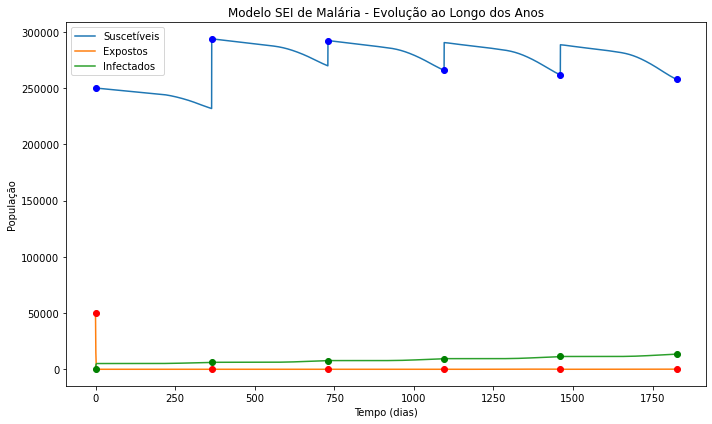

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

all_years_S_H = []
all_years_I_H = []
all_years_R_H = []

all_years_S_M = []
all_years_E_M = []
all_years_I_M = []

for year in range(2004, 2009):
    pop_rural = [7717, 7889, 8061, 8233, 8492]
    N = pop_rural[year - 2004]
    
    if year == 2004:
#         I_H0 = 1000
#         R_H0 = 0
        
#         E_M0 = 50000
#         I_M0 = 2500

        I_H0 = 1
        R_H0 = 0
        
        # Com um único mosquito exposto, a doença não se estabelece
        #E_M0 = 1, 10, 100
        # Começa a se estabelecer com 1000, mas ainda muito pouco
        E_M0 = 50000
        I_M0 = 0
        
    else:
        #I_H0 = all_years_I_H[-1][-1]
        #R_H0 = all_years_R_H[-1][-1]
        
        E_M0 = all_years_E_M[-1][-1]
        I_M0 = all_years_I_M[-1][-1]
        
    if E_M0 is None:
        E_M0 = M / 100
        
        
    S_H0 = N - I_H0 - R_H0
    S_M0 = M - E_M0 - I_M0
    
    args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   36.5, 0.04, A, B, C, 0.09, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)
    
    t_eval = np.linspace(0, 365, 1000)
    sol = solve_ivp(model, [0, 365], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
    times = sol.t
    S_H, I_H, R_H, S_M, E_M, I_M = sol.y
    
    all_years_S_M.append(S_M)
    all_years_E_M.append(E_M)
    all_years_I_M.append(I_M)

all_years_S_M = np.concatenate(all_years_S_M, axis=0)    
all_years_E_M = np.concatenate(all_years_E_M, axis=0)
all_years_I_M = np.concatenate(all_years_I_M, axis=0)

time_total = np.linspace(0, 1825, 1000 * 5)  # Tempo total de 5 anos

ax.plot(time_total, all_years_S_M, label='Suscetíveis')
ax.plot(time_total, all_years_E_M, label='Expostos')
ax.plot(time_total, all_years_I_M, label='Infectados')

time_points = [0, 365, 730, 1095, 1460, 1825]  # Tempos específicos

# Calcula os índices correspondentes nos arrays de tempo total
indices = [np.argmin(np.abs(time_total - t)) for t in time_points]

for index in indices:
    ax.plot(time_total[index], all_years_S_M[index], 'bo')  # Ponto azul para o valor no tempo específico
    ax.plot(time_total[index], all_years_E_M[index], 'ro')  # Ponto vermelho para o valor no tempo específico
    ax.plot(time_total[index], all_years_I_M[index], 'go')  # Ponto verde para o valor no tempo específico

ax.set_xlabel('Tempo (dias)')
ax.set_ylabel('População')
ax.set_title('Modelo SEI de Malária - Evolução ao Longo dos Anos')
ax.legend()

plt.tight_layout()
plt.show()

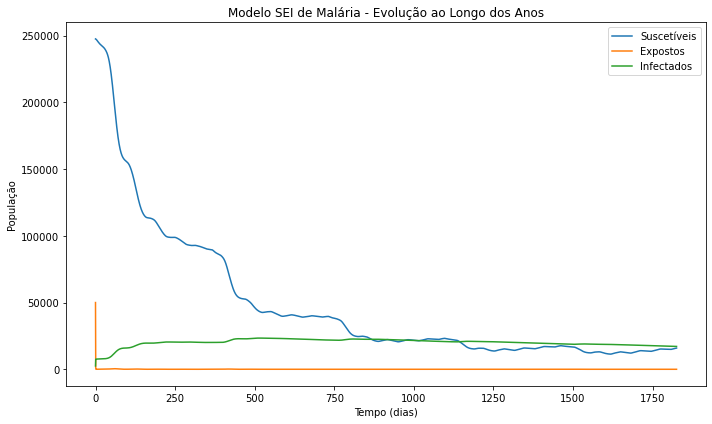

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

all_years_S_M = []
all_years_E_M = []
all_years_I_M = []

for year in range(2004, 2009):
    pop_rural = [7717, 7889, 8061, 8233, 8492]
    N = pop_rural[year - 2004]
    
    if E_M0 is None:
        E_M0 = M / 100
    
    if year == 2004:
        E_M0 = 50000
        I_M0 = 2500
        S_M0 = M - E_M0 - I_M0

    else:
#         I_H0 = all_years_I_H[-1][-1]
#         R_H0 = all_years_R_H[-1][-1]
        
        E_M0 = all_years_E_M[-1][-1]
        I_M0 = all_years_I_M[-1][-1]
        S_M0 = all_years_S_M[-1][-1]
        
        
        #S_H0 = N - I_H0 - R_H0
    
    
    args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)
    
    t_eval = np.linspace(0, 1825, 1000)
    sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
    times = sol.t
    S_H, I_H, R_H, S_M, E_M, I_M = sol.y
    
    all_years_S_M.append(S_M)
    all_years_E_M.append(E_M)
    all_years_I_M.append(I_M)

all_years_S_M = np.concatenate(all_years_S_M, axis=0)    
all_years_E_M = np.concatenate(all_years_E_M, axis=0)
all_years_I_M = np.concatenate(all_years_I_M, axis=0)

time_total = np.linspace(0, 1825, 1000 * 5)  # Tempo total de 5 anos

ax.plot(time_total, all_years_S_M, label='Suscetíveis')
ax.plot(time_total, all_years_E_M, label='Expostos')
ax.plot(time_total, all_years_I_M, label='Infectados')

ax.set_xlabel('Tempo (dias)')
ax.set_ylabel('População')
ax.set_title('Modelo SEI de Malária - Evolução ao Longo dos Anos')
ax.legend()

plt.tight_layout()
plt.show()